In [18]:
from sklearn import preprocessing
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import random
import time
from collections import deque

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping


hist = []
target = []
length = 90

epochs = 25
batch_size = 32

In [19]:
%matplotlib inline

In [20]:
df = pd.read_csv("../data/crypto-markets.csv", parse_dates=["date"], index_col="date")
df = df[df.slug == "bitcoin"]
df.drop(['slug', 'symbol', 'name', 'ranknow', 'open', 'volume', 'market'], axis=1, inplace=True)
df.tail()

,high,low,close,close_ratio,spread
date,,,,,
2018-11-25,4120.87,3585.06,4009.97,0.7930,535.81
2018-11-26,4107.14,3643.92,3779.13,0.2919,463.22
2018-11-27,3862.96,3661.01,3820.72,0.7908,201.95
2018-11-28,4385.90,3822.47,4257.42,0.7720,563.43
2018-11-29,4413.02,4145.77,4278.85,0.4980,267.25


Text(0.5, 1.0, 'BTC')

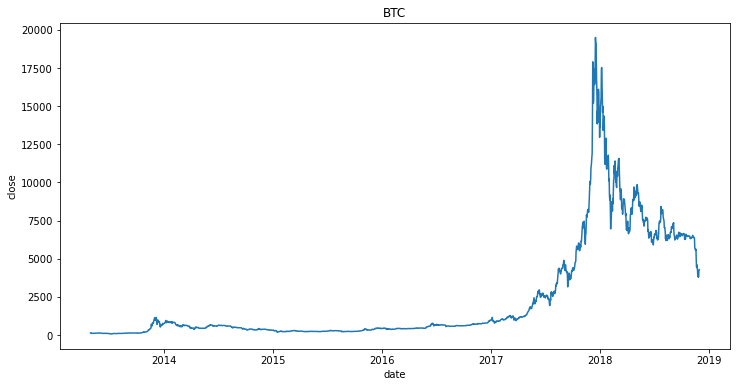

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y='close', data=df).set_title('BTC')

Text(0.5, 1.0, 'BTC downsampled')

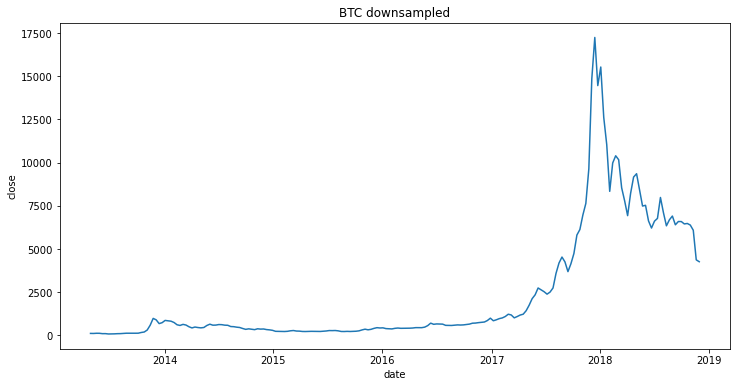

In [22]:
plt.figure(figsize=(12,6))
new_df = df.resample('10D').mean()
sns.lineplot(x=new_df.index, y='close', data=new_df).set_title('BTC downsampled')

In [23]:
data = df.iloc[:, 0]
data

date
2013-04-28     135.98
2013-04-29     147.49
2013-04-30     146.93
2013-05-01     139.89
2013-05-02     125.60
               ...   
2018-11-25    4120.87
2018-11-26    4107.14
2018-11-27    3862.96
2018-11-28    4385.90
2018-11-29    4413.02
Name: high, Length: 2042, dtype: float64

In [24]:
for i in range(len(data)-length):
    x = data[i:i+length]
    y = data[i+length]
    hist.append(x)
    target.append(y)

In [25]:
print(len(hist[0]))
print(len(hist))
print(len(target))

90
1952
1952


In [26]:
#convert list to array
hist = np.array(hist)
target = np.array(target)

In [27]:
target = target.reshape(-1,1)
target.shape

(1952, 1)

In [28]:
#Normalize the values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
hist_scaled = sc.fit_transform(hist)
target_scaled = sc.fit_transform(target)

In [29]:
#Reshape the input
hist_scaled = hist_scaled.reshape((len(hist_scaled), length, 1))
print(hist_scaled.shape)

(1952, 90, 1)


In [30]:
X_train = hist_scaled[:1900,:,:]
X_test = hist_scaled[1900:,:,:]

y_train = target_scaled[:1900,:]
y_test = target_scaled[1900:,:]

In [31]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

1900
52
1900
52


In [34]:
lstm_units = [32, 64, 128]

for units in lstm_units:
        name = f"u-{units}-seq_length[{length}]-t{int(time.time())}"
        print(name)

        model = Sequential()
        model.add(LSTM(units,input_shape=(X_train.shape[1:]), return_sequences=True))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(LSTM(units,  return_sequences=True))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(LSTM(units))
        model.add(Dropout(0.2))
        model.add(BatchNormalization())

        model.add(Dense(units / 2, activation='relu'))
        model.add(Dropout(0.2))

        model.add(Dense(1, activation='softmax'))

        model.summary()


        # Compile model
        model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy']
        )

        tensorboard = TensorBoard(log_dir="logs/{}".format(name))

        filepath = "models/acc-{val_accuracy:.3f}-RNN-{epoch:02d}.h5"  # unique file name that will include the epoch and the validation acc for that epoch
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # saves only the best ones

        # Train model
        history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_test, y_test),
            callbacks=[[tensorboard, checkpoint]]
        )

        # Score model
        score = model.evaluate(X_test, y_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        # Save model
        model.save("models/{}".format(name))

u-32-seq_length[90]-t1597173822
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 90, 32)            4352      
_________________________________________________________________
dropout_16 (Dropout)         (None, 90, 32)            0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 90, 32)            128       
_________________________________________________________________
lstm_14 (LSTM)               (None, 90, 32)            8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 90, 32)            0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 90, 32)            128       
_________________________________________________________________
lstm_15 (LSTM)        

KeyboardInterrupt: 